In [1]:
using ITensorMPS
using ITensors
using Plots
using DelimitedFiles

# One-Particle Propogation

In [2]:
N_s = 16
cutoff = 1E-8

# Make an array of 'site' indices
s = siteinds("S=1/2", N_s)

# State Preparation
vacs = ["Up" for n = 1:N_s]
vac = MPS(s, vacs)
n_kr = 4
c = [i for i=(-N_s/2+1):(N_s/2)]
# r = append!(c[24:N_s], c[1:23])
state = MPS(s, vacs)
wp_width=3

for xr in 1:N_s
    pstate = MPS(s, vacs)

    rmom_exp = exp(-1im * n_kr * pi / N_s * xr)
    rgauss_exp = exp(- c[xr]^2 / (wp_width/2)^2)
    rpref = rmom_exp * rgauss_exp
    # Apply CDAG[xr]
    pstate = apply(2 * op("S-", s[xr]), pstate; cutoff)
    if xr != 1
        for j in 1:(xr-1)
            pstate = apply(- op("Z", s[j]), pstate; cutoff)
        end
    end

    normalize!(pstate)
    state += rpref * pstate
end
state -= vac

InterruptException: InterruptException:

[4.9460964157699294e-8, 3.1690392740535422e-6, 0.00010706418065575818, 0.0019072705619549435, 0.01791562424322868, 0.08873666777999167, 0.23175324230432487, 0.3191538244521625, 0.23175324230432393, 0.088736667779992, 0.017915624243229455, 0.001907270561955443, 0.00010706418065681289, 3.169039274664165e-6, 4.9460964601788504e-8, 4.070516146370551e-10]


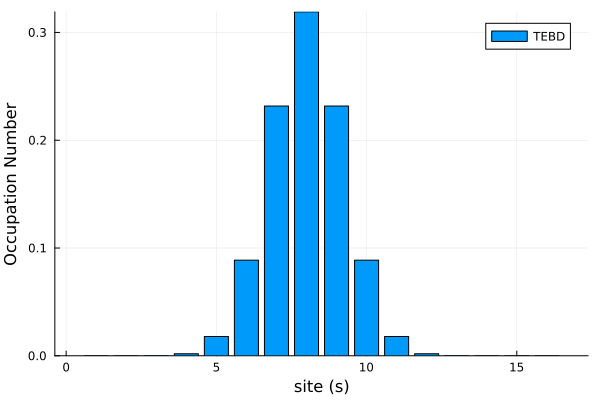

In [13]:
magz = expect(state, "Sz")
occs = [(1 - 2 * magz[n])/2 for n=1:N_s]
println(occs)

sites = [n for n=1:N_s]
plot(bar(sites, occs; label="TEBD"); xlabel="site (s)", ylabel="Occupation Number")

In [14]:
# Make Time-Evolution Gates
lam = 0.2
# eps = 0.1
tau = 0.2
beta_tau = -log(tau) / 2
N_t = 300

gates = ITensor[]
for j in 1:N_s
    s1 = s[j]
    if j == N_s
        s2 = s[1]
    else
        s2 = s[j+1]
    end
    
    x1 = op("X", s1)
    x2 = op("X", s2)

    hxx = - lam * x1 * x2

    Gj = exp(-1im * tau / 2 * hxx)

    push!(gates, Gj)

    # hx = - eps * x1
    # Gj = exp(-1im * tau / 2 * hx)

    # push!(gates, Gj)

    hz = - op("Z", s1)
    Gj = exp(-1im * tau / 2 * hz)
    push!(gates, Gj)
end

# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
append!(gates, reverse(gates))

64-element Vector{ITensor}:
 ITensor ord=4
Dim 1: (dim=2|id=981|"S=1/2,Site,n=1")
Dim 2: (dim=2|id=791|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=981|"S=1/2,Site,n=1")'
Dim 4: (dim=2|id=791|"S=1/2,Site,n=2")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 0.9998000066665779 + 0.0im  0.0 + 0.0im
                0.0 + 0.0im  0.0 + 0.019998666693333084im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.019998666693333084im
 0.9998000066665779 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im                  0.9998000066665778 + 0.0im
 0.0 + 0.01999866669333308im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.01999866669333308im                 0.0 + 0.0im
 0.0 + 0.0im                  0.9998000066665778 + 0.0im
 ITensor ord=2
Dim 1: (dim=2|id=981|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=981|"S=1/2,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.9950041652780257 + 0.09983341664682814im  …                 0.0 + 0.0im
                0.0 + 0.0im    

In [15]:
# Compute and print <Sz> at each time step
# then apply the gates to go to the next time
maxdim = 20
occs = []
ttotal = N_t * tau
j = 0
for t in 0:tau:ttotal
    if mod(j, 100) == 0
        println(j)
    end
    j += 1
    # println("Pass 1")
    Sz = expect(state, "Sz")
    occ = [(1 - 2 * Sz[n])/2 for n=1:N_s]
    push!(occs, occ)


    t ≈ ttotal && break

    state = apply(gates, state; cutoff, maxdim)
    normalize!(state)
end

0
100
200
300


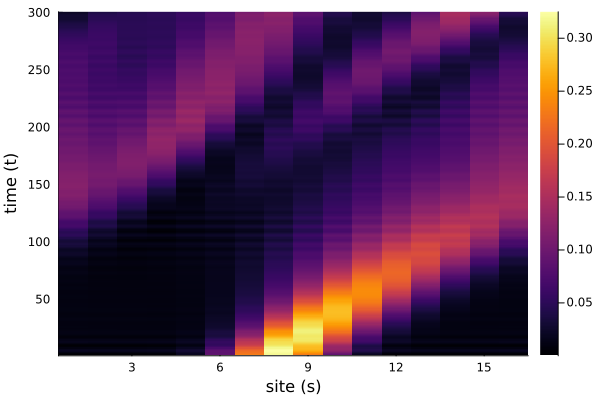

In [16]:
plot_times = zeros((N_t))
plot_occs = zeros((N_t, N_s))
for i in 1:N_t
    plot_times[i] = (i-1) * tau
    for j in 1:N_s
        plot_occs[i,j] = occs[i][j]
    end
end

plot_sites = zeros((N_s))
for i in 1:N_s
    plot_sites[i] = i
end

heatmap(plot_occs, xlabel="site (s)", ylabel="time (t)")

In [7]:
writedlm("N64-one-part-dmrg-lam0.2-dt0.04.txt", plot_occs)
# writedlm("N16-one-part-int-dmrg-lam02-eps01.txt", plot_occs)

# Two-Particle Scattering

In [3]:
# N_s = 16
# sites = siteinds("S=1/2", N_s)

# lam = 0.2

# os = OpSum()
# for j=1:N_s
#     if j == N_s
#         os -= lam, "X", j, "X", 1
#     else
#         os -= lam, "X", j, "X", j+1
#     end
#     os -= "Z", j
# end
# H = MPO(os, sites)

# psi0 = randomMPS(sites; linkdims=10)

# nsweeps = 15
# maxdim = [10,20,100,100,200]
# cutoff = [1E-10]
# noise = [1E-6]
# weight = 50

# energy0,psi0 = dmrg(H,psi0;nsweeps,maxdim,cutoff)

In [4]:
N_s = 16
cutoff = 1E-8
maxdim = 20

# Make an array of 'site' indices
s = siteinds("S=1/2", N_s)

# State Preparation
vacs = ["Up" for n = 1:N_s]
vac = MPS(s, vacs)
n_kr = 5
n_kl = -5
c = [i for i=(-N_s/2+1):(N_s/2)]
r = circshift(c, -5)
l = circshift(c, 3)
sigma = 3/2


init_state = vac

for xr in 1:N_s
    for xl in 1:N_s
        if xr != xl
            pstate = vac

            rmom_exp = exp(-1im * n_kr * pi / N_s * xr)
            rgauss_exp = exp(- r[xr]^2 / (sigma)^2)
            rpref = rmom_exp * rgauss_exp
            # Apply CDAG[xr]
            pstate = apply(op("X", s[xr]) - 1im * op("Y", s[xr]), pstate; cutoff)
            if xr != 1
                for j in 1:(xr-1)
                    pstate = apply(- op("Z", s[j]), pstate; cutoff)
                end
            end
            
            lmom_exp = exp(-1im * n_kl * pi / N_s * xl)
            lgauss_exp = exp(- l[xl]^2 / (sigma)^2)
            lpref = lmom_exp * lgauss_exp
            # Apply CDAG[xl]
            pstate = apply(op("X", s[xl]) - 1im  * op("Y", s[xl]), pstate; cutoff)
            if xl != 1
                for j in 1:(xl-1)
                    pstate = apply(- op("Z", s[j]), pstate; cutoff)
                end
            end

            normalize!(pstate)
            init_state += rpref * lpref * pstate
            
        end
    end
end
init_state -= vac

MPS
[1] ((dim=2|id=253|"S=1/2,Site,n=1"), (dim=3|id=128|"Link,l=1"))
[2] ((dim=2|id=963|"S=1/2,Site,n=2"), (dim=4|id=725|"Link,l=2"), (dim=3|id=128|"Link,l=1"))
[3] ((dim=2|id=83|"S=1/2,Site,n=3"), (dim=3|id=138|"Link,l=3"), (dim=4|id=725|"Link,l=2"))
[4] ((dim=2|id=44|"S=1/2,Site,n=4"), (dim=3|id=990|"Link,l=4"), (dim=3|id=138|"Link,l=3"))
[5] ((dim=2|id=707|"S=1/2,Site,n=5"), (dim=3|id=149|"Link,l=5"), (dim=3|id=990|"Link,l=4"))
[6] ((dim=2|id=780|"S=1/2,Site,n=6"), (dim=4|id=997|"Link,l=6"), (dim=3|id=149|"Link,l=5"))
[7] ((dim=2|id=908|"S=1/2,Site,n=7"), (dim=4|id=538|"Link,l=7"), (dim=4|id=997|"Link,l=6"))
[8] ((dim=2|id=99|"S=1/2,Site,n=8"), (dim=4|id=223|"Link,l=8"), (dim=4|id=538|"Link,l=7"))
[9] ((dim=2|id=727|"S=1/2,Site,n=9"), (dim=4|id=220|"Link,l=9"), (dim=4|id=223|"Link,l=8"))
[10] ((dim=2|id=844|"S=1/2,Site,n=10"), (dim=4|id=820|"Link,l=10"), (dim=4|id=220|"Link,l=9"))
[11] ((dim=2|id=664|"S=1/2,Site,n=11"), (dim=4|id=853|"Link,l=11"), (dim=4|id=820|"Link,l=10"))
[12] ((

[0.015194190313907063, 0.21867351133349322, 0.5319070162827505, 0.218673512875806, 0.015194190925688411, 0.00017843506659431796, 7.083255464945815e-7, 0.0001784350445054872, 0.015194190307127486, 0.2186735120504466, 0.5319070168753034, 0.21867351204486735, 0.015194190307512179, 0.0001784350444015148, 7.08325577525315e-7, 0.0001784348764726773]


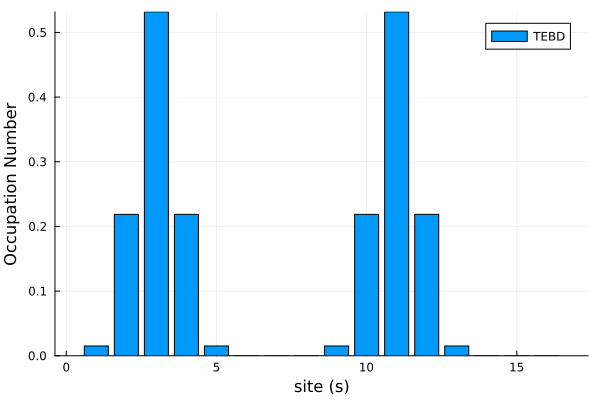

In [5]:
magz = expect(init_state, "Z")
occs = [(1 - magz[n])/2 for n=1:N_s]
println(occs)

sites = [n for n=1:N_s]
plot(bar(sites, occs; label="TEBD"), xlabel="site (s)", ylabel="Occupation Number")

In [6]:
# Make Time-Evolution Gates
lam = 0.2
tau = 0.1
N_t = 350
eps = 0.1

gates = ITensor[]
for j in 1:N_s
    s1 = s[j]
    if j == N_s
        s2 = s[1]
    else
        s2 = s[j+1]
    end
    
    x1 = op("X", s1)
    x2 = op("X", s2)

    hxx = - lam * x1 * x2

    Gj = exp(-1im * tau / 2 * hxx)

    push!(gates, Gj)

    hz = - op("Z", s1)
    Gj = exp(-1im * tau / 2 * hz)
    push!(gates, Gj)

    z1 = op("Z", s1)
    z2 = op("Z", s2)

    hzz = eps * z1 * z2

    Gj = exp(-1im * tau / 2 * hzz)
    push!(gates, Gj)
end

# Include gates in reverse order too
# (N,N-1),(N-1,N-2),...
append!(gates, reverse(gates))

96-element Vector{ITensor}:
 ITensor ord=4
Dim 1: (dim=2|id=253|"S=1/2,Site,n=1")
Dim 2: (dim=2|id=963|"S=1/2,Site,n=2")
Dim 3: (dim=2|id=253|"S=1/2,Site,n=1")'
Dim 4: (dim=2|id=963|"S=1/2,Site,n=2")'
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 0.9999500004166653 + 0.0im  0.0 + 0.0im
                0.0 + 0.0im  0.0 + 0.009999833334166664im

[:, :, 2, 1] =
                0.0 + 0.0im  0.0 + 0.009999833334166664im
 0.9999500004166653 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im                   0.9999500004166652 + 0.0im
 0.0 + 0.009999833334166664im                 0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.009999833334166664im                 0.0 + 0.0im
 0.0 + 0.0im                   0.9999500004166652 + 0.0im
 ITensor ord=2
Dim 1: (dim=2|id=253|"S=1/2,Site,n=1")'
Dim 2: (dim=2|id=253|"S=1/2,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
 0.9987502603949664 + 0.04997916927067834im  …                 0.0 + 0.0im
                0.0 + 0.0im

In [7]:
# Compute and print <Sz> at each time step
# then apply the gates to go to the next time
maxdim = 20
occs = []
ttotal = N_t * tau
state = init_state
for t in 0:tau:ttotal
    
    # println("Pass 1")
    Sz = expect(state, "Z")
    occ = [(1 - Sz[n])/2 for n=1:N_s]
    push!(occs, occ)


    t ≈ ttotal && break

    state = apply(gates, state; cutoff, maxdim)
    normalize!(state)
end

In [12]:
# sites = [n for n=1:N_s]
# for p in 1:length(occs)
#     if (p - 1) % 10 == 0
#         plt = plot(bar(sites, occs[p]; label="TEBD"); ylims= (0,0.6), xlabel="site")
#         png(plt, "Plots/plt" * string(p) * ".png")
#     end
# end

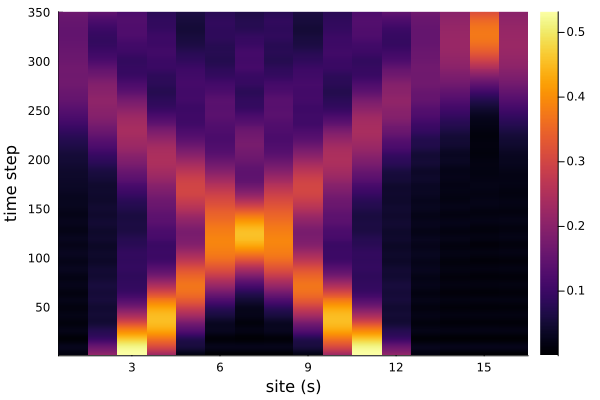

In [8]:
plot_times = zeros((N_t))
plot_occs = zeros((N_t, N_s))
for i in 1:N_t
    plot_times[i] = (i - 1) * tau
    for j in 1:N_s
        plot_occs[i,j] = occs[i][j]
    end
end

plot_sites = zeros((N_s))
for i in 1:N_s
    plot_sites[i] = i
end

heatmap(plot_occs, xlabel="site (s)", ylabel="time step")

In [9]:
title = "2-part-inter-N_s" * string(N_s)
title *= "-lam" * string(lam)
title *= "-eps" * string(eps)
title *= "-width" * string(sigma)
title *= "-dt" * string(tau) * ".txt"
writedlm(title, plot_occs)

In [10]:
println(title)

2-part-inter-N_s16-lam0.2-eps0.1-width1.5-dt0.1.txt


In [39]:
approx_occs = readdlm("2-part-approx-N_s10-lam0.2-width3-dt0.1.txt")

200×10 Matrix{Float64}:
 0.0152031  0.218802   0.53222   …  0.218802  0.0152031  3.33067e-16
 0.0141051  0.210043   0.532057     0.210043  0.0140934  0.00077966
 0.0144524  0.202137   0.531562     0.202137  0.0144076  0.00299234
 0.0159602  0.195038   0.530719     0.195038  0.0158664  0.00628036
 0.0181776  0.188598   0.529497     0.1886    0.0180269  0.0101138
 0.0205608  0.182584   0.527857  …  0.182588  0.0203547  0.013879
 0.0225612  0.176713   0.525745     0.176725  0.0223099  0.0169808
 0.0237141  0.170704   0.523101     0.17073   0.0234353  0.0189398
 0.0237133  0.164315   0.519859     0.164365  0.023429   0.0194709
 0.0224588  0.157393   0.51596      0.157476  0.0221918  0.0185263
 ⋮                               ⋱                       
 0.267154   0.13419    0.142699     0.189779  0.258791   0.472094
 0.266702   0.127654   0.1433       0.185525  0.257078   0.482195
 0.26629    0.121523   0.144432     0.181629  0.255665   0.491983
 0.266      0.115924   0.146167     0.178137  

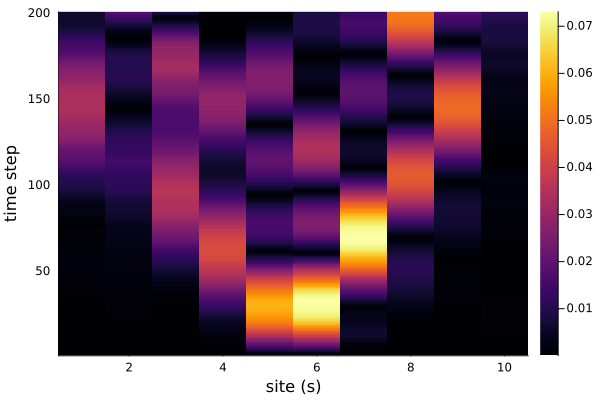

In [11]:
diff = zeros((N_t, N_s))
for i in 1:N_t
    for j in 1:N_s
        diff[i,j] = abs(plot_occs[i, j] - approx_occs[i, j])
    end
end
heatmap(diff, xlabel="site (s)", ylabel="time step")

In [17]:
approx_occs[10][10]

BoundsError: BoundsError: attempt to access Float64 at index [10]